In [1]:
import numpy as np
import pandas as pd
import json as json
from scipy import stats
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [2]:
from o_plot import opl # a small local package dedicated to this project

In [3]:
# Prepare the data

In [4]:
# loading the data
file_name = 'Up_to_Belem_TE4AL2_data_new.json'
f = open(file_name)
All_data = json.load(f)
print(len(All_data))

148


## Note for the interpretation of the curves and definition of the statistical variables

The quantum state classifier (QSC) error rates $\widehat{r}_i$ in function of the number of experimental shots $n$ were determined for each highly entangled quantum state $\omega_i$ in the $\Omega$ set, with $i=1...m$.

The curves seen on the figures represents the mean of the QSC error rate $\widehat{r}_{mean}$ over the $m$ quantum states at each $n$ value.

This Monte Carlo simulation allowed to determine a safe shot number $n_s$ such that $\forall i\; \widehat{r}_i\le \epsilon_s$. The value of $\epsilon_s$ was set at 0.001.

$\widehat{r}_{max}$ is the maximal value observed among all the $\widehat{r}_i$ values for the determined  number of shots $n_s$.

Similarly, from the error curves stored in the data file, was computed the safe shot number $n_t$ such that $\widehat{r}_{mean}\le \epsilon_t$. The value of $\epsilon_t$ was set at 0.0005 after verifying that all $\widehat{r}_{mean}$ at $n_s$ were $\le \epsilon_s$ in the different experimental settings. 

Correspondance between variables names in the text and in the data base:

- $\widehat{r}_{mean}$: error_curve
- $n_s$: shots
- max ($\widehat{r}_i$) at $n_s$: shot_rate
- $\widehat{r}_{mean}$ at $n_s$: mns_rate
- $n_t$: m_shots
- $\widehat{r}_{mean}$ at $n_t$: m_shot_rate




In [5]:
# Calculate shot number 'm_shots' for mean error rate 'm_shot_rates' <= epsilon_t
len_data = len(All_data)
epsilon_t = 0.0005
window = 11
for i in range(len_data):            
    curve = np.array(All_data[i]['error_curve'])
    # filter the curve only for real devices:
    if All_data[i]['device']!="ideal_device":    
        curve = savgol_filter(curve,window,2) 
    # find the safe shot number:    
    len_c = len(curve)                               
    n_a = np.argmin(np.flip(curve)<=epsilon_t)+1                          
    if n_a == 1:
        n_a = np.nan
        m_r = np.nan
    else:
        m_r = curve[len_c-n_a+1]
    All_data[i]['min_r_shots'] = len_c-n_a
    All_data[i]['min_r'] = m_r

In [6]:
# find mean error rate at n_s
for i in range(len_data):
    i_shot = All_data[i]["shots"]
    if not np.isnan(i_shot):
        j = int(i_shot)-1        
        All_data[i]['mns_rate'] = All_data[i]['error_curve'][j]
    else:
        All_data[i]['mns_rate'] = np.nan

In [7]:
#defining the pandas data frame for statistics excluding from here ibmqx2 data
df_All= pd.DataFrame(All_data,columns=['shot_rates','shots', 'device', 'fidelity',
                                        'mitigation','model','id_gates',
                                        'QV', 'metric','error_curve',
                                        'mns_rate','min_r_shots',
                                        'min_r']).query("device != 'ibmqx2'")

# any shot number >= 488 indicates that the curve calculation 
# was ended after reaching n = 500, hence this data correction:
df_All.loc[df_All.shots>=488,"shots"]=np.nan

# add the variable neperian log of safe shot number: 
df_All['log_shots'] = np.log(df_All['shots'])
df_All['log_min_r_shots'] = np.log(df_All['min_r_shots'])

# add the delta shots variables 
# we know that we need 16 shots anyway in the ideal conditions for this case
# THIS LINE OF CODE FOR AVERAGE THRESHOLD OPTION
df_All['d_shots'] = df_All['min_r_shots'] - 14 # this  is valid for both metrics


### Error rates in function of chosen $\epsilon_s$ and $\epsilon_t$

In [8]:
print("max mean error rate at n_s over all experiments =", round(max(df_All.mns_rate[:-2]),6))

max mean error rate at n_s over all experiments = 0.000515


In [9]:
print("min mean error rate at n_t over all experiments =", round(min(df_All.min_r[:-2]),6))

min mean error rate at n_t over all experiments = 0.000225


In [10]:
print("max mean error rate at n_t over all experiments =", round(max(df_All.min_r[:-2]),6))

max mean error rate at n_t over all experiments = 0.0005


<AxesSubplot:ylabel='Frequency'>

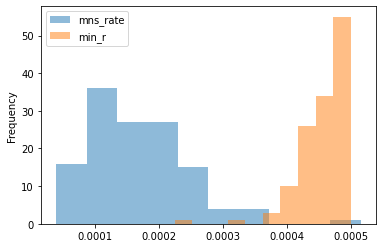

In [11]:
df_All.mns_rate[:-2].plot.hist(alpha=0.5, legend = True)
df_All.min_r[:-2].plot.hist(alpha=0.5, legend = True)

### Determine the options
Running sequentially these cells will end up with the main streaming options

In [12]:
# this for Jensen-Shannon metric 
s_metric = 'jensenshannon'
sm = np.array([96+16+16+16]) # added Quito and Lima and Belem
SAD=0
# ! will be unselected by running the next cell

In [13]:
# mainstream option for metric: squared euclidean distance
# skip this cell if you don't want this option
s_metric = 'sqeuclidean'
sm = np.array([97+16+16+16]) # added Quito and Lima and Belem
SAD=2   

## 1. Compare distribution models


In [14]:
# this for no mitigation
mit = 'no'
MIT=-4

In [15]:
# select data according to the options
df_mod = df_All[df_All.mitigation == mit][df_All.metric == s_metric]

<ipython-input-15-af347b9ea33a>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_mod = df_All[df_All.mitigation == mit][df_All.metric == s_metric]


In [16]:
print("mitigation:",mit,"  metric:",s_metric )
df_mod.groupby('device')[['d_shots','min_r_shots']].describe(percentiles=[0.5])

mitigation: no   metric: sqeuclidean


d_shots                                        min_r_shots  \
                count    mean         std   min   50%    max       count   
device                                                                     
ibmq_athens       4.0   25.75   15.261608  13.0  22.5   45.0         4.0   
ibmq_belem        4.0   35.50   22.708295  17.0  29.0   67.0         4.0   
ibmq_lima         4.0   71.00   71.712389  24.0  42.0  176.0         4.0   
ibmq_ourense      4.0   28.75    9.810708  19.0  27.5   41.0         4.0   
ibmq_quito        4.0  107.75  108.444686  28.0  67.5  268.0         4.0   
ibmq_santiago     4.0   21.25    6.291529  14.0  22.0   27.0         4.0   
ibmq_valencia     4.0   31.00    9.556847  20.0  31.0   42.0         4.0   
ibmq_vigo         4.0   24.00   11.518102  14.0  21.5   39.0         4.0   

                                                      
                 mean         std   min   50%    max  
device                                                
ibmq_athens     39.75   15.261608  27.0  36.5   59.0  
ibmq_belem      49.50   22.708295  31.0  43.0   81.0  
ibmq_lima       85.00   71.712389  38.0  56.0  190.0  
ibmq_ourense    42.75    9.810708  33.0  41.5   55.0  
ibmq_quito     121.75  108.444686  42.0  81.5  282.0  
ibmq_santiago   35.25    6.291529  28.0  36.0   41.0  
ibmq_valencia   45.00    9.556847  34.0  45.0   56.0  
ibmq_vigo       38.00   11.518102  28.0  35.5   53.0

## Ideal vs empirical model: 

## without mitigation

### excess shots for creation + Bob measurement

#### Paired t-test and Wilcoxon test

In [18]:
for depvar in ['d_shots' ]:
    print("mitigation:",mit,"  metric:",s_metric, "variable:", depvar)
    df_dep = df_mod.query("id_gates == 0.0").groupby(['model'])[depvar]
    print(df_dep.describe(percentiles=[0.5]),"\n")
    # no error rate curve obtained for ibmqx2 with the ideal model, hence this exclusion:
    df_emp=df_mod.query("model == 'empirical' & id_gates == 0.0")
    df_ide=df_mod.query("model == 'ideal_sim' & id_gates == 0.0")  #.reindex_like(df_emp,'nearest')
    # back to numpy arrays from pandas: 
    print("paired data")
    print(np.asarray(df_emp[depvar]))
    print(np.asarray(df_ide[depvar]),"\n")

    print(stats.ttest_rel(np.asarray(df_emp[depvar]),np.asarray(df_ide[depvar])))
    print(stats.wilcoxon(np.asarray(df_emp[depvar]),np.asarray(df_ide[depvar])),"\n")
# added for delta calculations
cb_shots_emp = np.asarray(df_emp[depvar])
cb_shots_ide = np.asarray(df_ide[depvar])

mitigation: no   metric: sqeuclidean variable: d_shots
           count    mean        std   min   50%   max
model                                                
empirical    8.0  18.625   5.289815  13.0  18.0  28.0
ideal_sim    8.0  27.500  17.262677  14.0  22.0  67.0 

paired data
[14. 13. 20. 14. 19. 28. 24. 17.]
[18. 14. 35. 16. 23. 67. 26. 21.] 

Ttest_relResult(statistic=-1.9392621029650916, pvalue=0.09363669481734965)
WilcoxonResult(statistic=0.0, pvalue=0.0078125) 



### excess shots for creation + transmission time of 256  id gates + Bob measurement

#### Paired t-test and Wilcoxon test

In [19]:
for depvar in ['d_shots' ]:
    print("mitigation:",mit,"  metric:",s_metric, "variable:", depvar)
    df_dep = df_mod.query("id_gates == 256.0 ").groupby(['model'])[depvar]
    print(df_dep.describe(percentiles=[0.5]),"\n")
    # no error rate curve obtained for ibmqx2   with the ideal model, hence their exclusion:
    df_emp=df_mod.query("model == 'empirical' & id_gates == 256.0 ")
    df_ide=df_mod.query("model == 'ideal_sim' & id_gates == 256.0")  #.reindex_like(df_emp,'nearest') 
    # back to numpy arrays from pandas: 
    print("paired data")
    print(np.asarray(df_emp[depvar]))
    print(np.asarray(df_ide[depvar]),"\n")
    
    print(stats.ttest_rel(np.asarray(df_emp[depvar]),np.asarray(df_ide[depvar])))
    print(stats.wilcoxon(np.asarray(df_emp[depvar]),np.asarray(df_ide[depvar])),"\n")
# added for delta calculations
tb_shots_emp = np.asarray(df_emp[depvar])
tb_shots_ide = np.asarray(df_ide[depvar])

mitigation: no   metric: sqeuclidean variable: d_shots
           count    mean        std   min   50%    max
model                                                 
empirical    8.0  38.375  15.801786  27.0  31.5   68.0
ideal_sim    8.0  88.000  87.017240  26.0  43.5  268.0 

paired data
[27. 31. 27. 27. 32. 68. 58. 37.]
[ 26.  45.  42.  39.  41. 268. 176.  67.] 

Ttest_relResult(statistic=-1.9635222279074889, pvalue=0.09034957260966052)
WilcoxonResult(statistic=1.0, pvalue=0.015625) 



### excess shots for  transmission time of 256  id gates + Bob measurement

In [20]:

print("mitigation:",mit,"  metric:",s_metric)
d_tb_emp = tb_shots_emp-cb_shots_emp
d_tb_ide = tb_shots_ide-cb_shots_ide
print(np.mean(d_tb_emp), '+/-',np.std(d_tb_emp))
print(np.mean(d_tb_ide), '+/-', np.std(d_tb_ide))
print(d_tb_emp)
print(d_tb_ide)
print(stats.ttest_rel(tb_shots_emp-cb_shots_emp,tb_shots_ide-cb_shots_ide))
print(stats.wilcoxon(tb_shots_emp-cb_shots_emp,tb_shots_ide-cb_shots_ide))

mitigation: no   metric: sqeuclidean
19.75 +/- 10.697546447667333
60.5 +/- 68.61304540683207
[13. 18.  7. 13. 13. 40. 34. 20.]
[  8.  31.   7.  23.  18. 201. 150.  46.]
Ttest_relResult(statistic=-1.8528367853664818, pvalue=0.10632354920663743)
WilcoxonResult(statistic=1.5, pvalue=0.034287967973591744)


C:\Users\decpi\Anaconda3\envs\QK25\lib\site-packages\scipy\stats\morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\decpi\Anaconda3\envs\QK25\lib\site-packages\scipy\stats\morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


## with mitigation

In [21]:
mit = 'yes'
MIT= 0

In [22]:
# select data according to the options
df_mod = df_All[df_All.mitigation == mit][df_All.metric == s_metric]

<ipython-input-22-af347b9ea33a>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_mod = df_All[df_All.mitigation == mit][df_All.metric == s_metric]


In [23]:
print("mitigation:",mit,"  metric:",s_metric )
df_mod.groupby('device')[['d_shots','min_r_shots']].describe(percentiles=[0.5])

mitigation: yes   metric: sqeuclidean


d_shots                                      min_r_shots         \
                count   mean        std   min   50%    max       count   mean   
device                                                                          
ibmq_athens       4.0  19.00  11.575837   9.0  17.0   33.0         4.0  33.00   
ibmq_belem        4.0  18.75  13.200379   7.0  16.0   36.0         4.0  32.75   
ibmq_lima         4.0  26.25  22.035955   8.0  21.0   55.0         4.0  40.25   
ibmq_ourense      4.0  13.25   4.991660   9.0  12.0   20.0         4.0  27.25   
ibmq_quito        4.0  62.75  55.162638  17.0  45.5  143.0         4.0  76.75   
ibmq_santiago     4.0  13.75   5.123475   8.0  14.0   19.0         4.0  27.75   
ibmq_valencia     4.0  11.75   4.787136   5.0  13.0   16.0         4.0  25.75   
ibmq_vigo         4.0  12.25   7.544314   5.0  11.5   21.0         4.0  26.25   

                                             
                     std   min   50%    max  
device                                       
ibmq_athens    11.575837  23.0  31.0   47.0  
ibmq_belem     13.200379  21.0  30.0   50.0  
ibmq_lima      22.035955  22.0  35.0   69.0  
ibmq_ourense    4.991660  23.0  26.0   34.0  
ibmq_quito     55.162638  31.0  59.5  157.0  
ibmq_santiago   5.123475  22.0  28.0   33.0  
ibmq_valencia   4.787136  19.0  27.0   30.0  
ibmq_vigo       7.544314  19.0  25.5   35.0

### excess shots for creation 

#### Paired t-test and Wilcoxon test

In [24]:
for depvar in ['d_shots' ]:
    print("mitigation:",mit,"  metric:",s_metric, "variable:", depvar)
    df_dep = df_mod.query("id_gates == 0.0").groupby(['model'])[depvar]
    print(df_dep.describe(percentiles=[0.5]),"\n")
    # no error rate curve obtained for ibmqx2 with the ideal model, hence this exclusion:
    df_emp=df_mod.query("model == 'empirical' & id_gates == 0.0 ")
    df_ide=df_mod.query("model == 'ideal_sim' & id_gates == 0.0")  #.reindex_like(df_emp,'nearest')
    # back to numpy arrays from pandas: 
    print("paired data")
    print(np.asarray(df_emp[depvar]))
    print(np.asarray(df_ide[depvar]),"\n")

    print(stats.ttest_rel(np.asarray(df_emp[depvar]),np.asarray(df_ide[depvar])))
    print(stats.wilcoxon(np.asarray(df_emp[depvar]),np.asarray(df_ide[depvar])),"\n")
# added for delta calculations
c_shots_emp = np.asarray(df_emp[depvar])
c_shots_ide = np.asarray(df_ide[depvar])

mitigation: yes   metric: sqeuclidean variable: d_shots
           count    mean        std  min   50%   max
model                                               
empirical    8.0   8.625   3.814914  5.0   8.0  17.0
ideal_sim    8.0  14.625  12.827844  7.0  10.0  46.0 

paired data
[ 8. 10.  5.  5.  9. 17.  8.  7.]
[11.  9. 14.  7. 10. 46. 10. 10.] 

Ttest_relResult(statistic=-1.7450837288061014, pvalue=0.12448258001624288)
WilcoxonResult(statistic=1.5, pvalue=0.015625) 



### excess shots for creation + transmission time of 256  id gates

#### Paired t-test and Wilcoxon test

In [25]:
for depvar in ['d_shots' ]:
    print("mitigation:",mit,"  metric:",s_metric, "variable:", depvar)
    df_dep = df_mod.query("id_gates == 256.0 ").groupby(['model'])[depvar]
    print(df_dep.describe(percentiles=[0.5]),"\n")
    # no error rate curve obtained for ibmqx2   with the ideal model, hence their exclusion:
    df_emp=df_mod.query("model == 'empirical' & id_gates == 256.0 ")
    df_ide=df_mod.query("model == 'ideal_sim' & id_gates == 256.0")  #.reindex_like(df_emp,'nearest') 
    # back to numpy arrays from pandas: 
    print("paired data")
    print(np.asarray(df_emp[depvar]))
    print(np.asarray(df_ide[depvar]),"\n")
    
    print(stats.ttest_rel(np.asarray(df_emp[depvar]),np.asarray(df_ide[depvar])))
    print(stats.wilcoxon(np.asarray(df_emp[depvar]),np.asarray(df_ide[depvar])),"\n")
# added for delta calculations
t_shots_emp = np.asarray(df_emp[depvar])
t_shots_ide = np.asarray(df_ide[depvar])

mitigation: yes   metric: sqeuclidean variable: d_shots
           count    mean        std   min   50%    max
model                                                 
empirical    8.0  23.000  10.915258  12.0  20.5   45.0
ideal_sim    8.0  42.625  42.610990  16.0  27.0  143.0 

paired data
[19. 24. 12. 16. 14. 45. 32. 22.]
[ 17.  33.  16.  21.  20. 143.  55.  36.] 

Ttest_relResult(statistic=-1.7060754673307206, pvalue=0.13175979056715553)
WilcoxonResult(statistic=1.0, pvalue=0.015625) 



### excess shots for  transmission time of 256  id gates

In [26]:
print("mitigation:",mit,"  metric:",s_metric)
d_t_emp = t_shots_emp-c_shots_emp
d_t_ide = t_shots_ide-c_shots_ide

print(np.mean(d_t_emp), np.std(d_t_emp))
print(np.mean(d_t_ide), '+/-', np.std(d_t_ide))
print(d_t_emp)
print(d_t_ide)
print(stats.ttest_rel(t_shots_emp-c_shots_emp,t_shots_ide-c_shots_ide))
print(stats.wilcoxon(t_shots_emp-c_shots_emp,t_shots_ide-c_shots_ide))

mitigation: yes   metric: sqeuclidean
14.375 7.448783457719791
28.0 +/- 29.047375096555626
[11. 14.  7. 11.  5. 28. 24. 15.]
[ 6. 24.  2. 14. 10. 97. 45. 26.]
Ttest_relResult(statistic=-1.6077415665563122, pvalue=0.1519271176467331)
WilcoxonResult(statistic=6.0, pvalue=0.109375)
